# Download

In [1]:
WORKING_ENV = 'LOCAL' # Can be LABS, COLAB or PAPERSPACE
assert WORKING_ENV in ['LABS', 'COLAB', 'LOCAL']

import sys
import os
if WORKING_ENV == 'COLAB':
  from google.colab import drive
  drive.mount('/content/drive/')
  !pip install medmnist
  !pip install torch
  !pip install gputil
  !pip install psutil
  !pip install humanize
  ROOT = "/content/drive/MyDrive/ColabNotebooks/med-contrastive-project/"
  sys.path.append(ROOT + "./swav/")
  !nvidia-smi
  slurm_id = 0
elif WORKING_ENV == 'LABS':
  ROOT = "/vol/bitbucket/sx119/Contrastive-Medical-Image-Classification/"
  slurm_id = os.environ["SLURM_JOB_ID"]
else:
  ROOT = "/Users/xushitong/Contrastive-Medical-Image-Classification/"
  slurm_id = 0

# Import

In [2]:
import medmnist

import argparse
import math
import os
import shutil
import time
from logging import getLogger

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.distributed as dist
import torch.optim
import torchvision
import torchvision.transforms as transforms
import tqdm
# import loader

from utils import (
    bool_flag,
    initialize_exp,
    restart_from_checkpoint,
    fix_random_seeds,
    AverageMeter,
    init_distributed_mode,
)
from multicropdataset import MultiCropDataset
import resnet50 as resnet_models



/Users/xushitong/miniconda3/envs/med-contrast-env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Import packages
import os,sys,humanize,psutil,GPUtil

# Define function
def mem_report():
  print("CPU RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ))
  
  GPUs = GPUtil.getGPUs()
  for i, gpu in enumerate(GPUs):
    print('GPU {:d} ... Mem Free: {:.0f}MB / {:.0f}MB | Utilization {:3.0f}%'.format(i, gpu.memoryFree, gpu.memoryTotal, gpu.memoryUtil*100))

mem_report()

CPU RAM Free: 12.4 GB
GPU 0 ... Mem Free: 15101MB / 15360MB | Utilization   0%


# Hyperparameters

In [3]:
EPOCH_NUM = 1
BATCH_SIZE = 32
BASE_LEARNING_RATE = 0.001
FINAL_LR = 0.001
WARMUP_EPOCHS = 4
WARMUP_LR = 0.0005
TRAIN_SET_RATIO = 0.9
CROP_NUM = [2, 6]
CROP_SIZE = [224, 96]
MIN_SCALE_CROP = [0.14, 0.05]
MAX_SCALE_CROP = [1, 0.14]
PRINT_FREQ = 500
PROJ_HEAD_EPOCH_NUM = 1

trial_name = f"epochs{EPOCH_NUM}_batch{BATCH_SIZE}_lr-base{BASE_LEARNING_RATE}-final{FINAL_LR}-warmup{WARMUP_LR}_warmup-epoch{WARMUP_EPOCHS}_crop-num{CROP_NUM}-size{CROP_SIZE}_scale-crop-min{MIN_SCALE_CROP}-max{MAX_SCALE_CROP}_head-epoch{PROJ_HEAD_EPOCH_NUM}"
arg_command = \
f"--epochs {EPOCH_NUM} --batch_size {BATCH_SIZE} --base_lr {BASE_LEARNING_RATE}\
 --final_lr {FINAL_LR} --warmup_epochs {WARMUP_EPOCHS} --start_warmup {WARMUP_LR}\
 --nmb_crops {' '.join(map(str, CROP_NUM))} --size_crops {' '.join(map(str, CROP_SIZE))} --min_scale_crops {' '.join(map(str, MIN_SCALE_CROP))} --max_scale_crops {' '.join(map(str, MAX_SCALE_CROP))}\
 --data_path {ROOT}./datasets".split(" ")

print(f"Running command {arg_command}")


Running command ['--epochs', '1', '--batch_size', '64', '--base_lr', '0.001', '--final_lr', '0.001', '--warmup_epochs', '4', '--start_warmup', '0.0005', '--nmb_crops', '2', '6', '--size_crops', '224', '96', '--min_scale_crops', '0.14', '0.05', '--max_scale_crops', '1', '0.14', '--data_path', '/Users/xushitong/Contrastive-Medical-Image-Classification/./datasets']


In [4]:
# logger = getLogger()

parser = argparse.ArgumentParser(description="Implementation of SwAV")

#########################
#### data parameters ####
#########################
parser.add_argument("--data_path", type=str, default="/path/to/data",
                    help="path to dataset repository")
parser.add_argument("--nmb_crops", type=int, default=[2], nargs="+",
                    help="list of number of crops (example: [2, 6])")
parser.add_argument("--size_crops", type=int, default=[224], nargs="+",
                    help="crops resolutions (example: [224, 96])")
parser.add_argument("--min_scale_crops", type=float, default=[0.14], nargs="+",
                    help="argument in RandomResizedCrop (example: [0.14, 0.05])")
parser.add_argument("--max_scale_crops", type=float, default=[1], nargs="+",
                    help="argument in RandomResizedCrop (example: [1., 0.14])")

#########################
## swav specific params #
#########################
parser.add_argument("--crops_for_assign", type=int, nargs="+", default=[0, 1],
                    help="list of crops id used for computing assignments")
parser.add_argument("--temperature", default=0.1, type=float,
                    help="temperature parameter in training loss")
parser.add_argument("--epsilon", default=0.05, type=float,
                    help="regularization parameter for Sinkhorn-Knopp algorithm")
parser.add_argument("--sinkhorn_iterations", default=3, type=int,
                    help="number of iterations in Sinkhorn-Knopp algorithm")
parser.add_argument("--feat_dim", default=128, type=int,
                    help="feature dimension")
parser.add_argument("--nmb_prototypes", default=3000, type=int,
                    help="number of prototypes")
parser.add_argument("--queue_length", type=int, default=0,
                    help="length of the queue (0 for no queue)")
parser.add_argument("--epoch_queue_starts", type=int, default=15,
                    help="from this epoch, we start using a queue")

#########################
#### optim parameters ###
#########################
parser.add_argument("--epochs", default=100, type=int,
                    help="number of total epochs to run")
parser.add_argument("--batch_size", default=64, type=int,
                    help="batch size per gpu, i.e. how many unique instances per gpu")
parser.add_argument("--base_lr", default=4.8, type=float, help="base learning rate")
parser.add_argument("--final_lr", type=float, default=0, help="final learning rate")
parser.add_argument("--freeze_prototypes_niters", default=313, type=int,
                    help="freeze the prototypes during this many iterations from the start")
parser.add_argument("--wd", default=1e-6, type=float, help="weight decay")
parser.add_argument("--warmup_epochs", default=10, type=int, help="number of warmup epochs")
parser.add_argument("--start_warmup", default=0, type=float,
                    help="initial warmup learning rate")

#########################
#### dist parameters ###
#########################
parser.add_argument("--dist_url", default="env://", type=str, help="""url used to set up distributed
                    training; see https://pytorch.org/docs/stable/distributed.html""")
parser.add_argument("--world_size", default=-1, type=int, help="""
                    number of processes: it is set automatically and
                    should not be passed as argument""")
parser.add_argument("--rank", default=0, type=int, help="""rank of this process:
                    it is set automatically and should not be passed as argument""")
parser.add_argument("--local_rank", default=0, type=int,
                    help="this argument is not used and should be ignored")

#########################
#### other parameters ###
#########################
parser.add_argument("--arch", default="resnet50", type=str, help="convnet architecture")
parser.add_argument("--hidden_mlp", default=2048, type=int,
                    help="hidden layer dimension in projection head")
parser.add_argument("--workers", default=10, type=int,
                    help="number of data loading workers")
parser.add_argument("--checkpoint_freq", type=int, default=25,
                    help="Save the model periodically")
parser.add_argument("--use_fp16", type=bool_flag, default=True,
                    help="whether to train with mixed precision or not")
parser.add_argument("--sync_bn", type=str, default="pytorch", help="synchronize bn")
parser.add_argument("--syncbn_process_group_size", type=int, default=8, help=""" see
                    https://github.com/NVIDIA/apex/blob/master/apex/parallel/__init__.py#L58-L67""")
parser.add_argument("--dump_path", type=str, default=".",
                    help="experiment dump path for checkpoints and log")
parser.add_argument("--seed", type=int, default=31, help="seed")



_StoreAction(option_strings=['--seed'], dest='seed', nargs=None, const=None, default=31, type=<class 'int'>, choices=None, required=False, help='seed', metavar=None)

In [5]:
args = parser.parse_args(arg_command)
fix_random_seeds(args.seed)

# Dataset

In [6]:
pretrain_set = MultiCropDataset(
        torch.load(args.data_path + "/pretrain_set.data"),
        args.data_path,
        args.size_crops,
        args.nmb_crops,
        args.min_scale_crops,
        args.max_scale_crops,
        return_label=True
    )
pretrain_val_set = MultiCropDataset(
        torch.load(args.data_path + "/pretrain_val_set.data"),
        args.data_path,
        args.size_crops,
        args.nmb_crops,
        args.min_scale_crops,
        args.max_scale_crops,
        return_label=True
    )

val_dataset = MultiCropDataset(
        medmnist.PathMNIST("val", download=False, root=args.data_path),
        args.data_path,
        args.size_crops,
        args.nmb_crops,
        args.min_scale_crops,
        args.max_scale_crops,
        return_label=True
    )
test_dataset = medmnist.PathMNIST("test", download=False, root=ROOT + "/datasets/", 
                                  transform=transforms.Compose([
                                    transforms.Resize(224),
                                    transforms.ToTensor(),
                                    transforms.Normalize(
                                        mean=[0.485, 0.456, 0.406],
                                        std=[0.228, 0.224, 0.225])
                                  ]))

pretrain_loader = torch.utils.data.DataLoader(
    pretrain_set, batch_size=args.batch_size, shuffle=True, 
    pin_memory=True, drop_last=True)
pretrain_val_loader = torch.utils.data.DataLoader(
    pretrain_val_set, batch_size=2 * args.batch_size, shuffle=False, 
    pin_memory=True, drop_last=True)

val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=2 * args.batch_size, shuffle=True, 
    pin_memory=True, drop_last=True)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=2 * args.batch_size, shuffle=False, 
    pin_memory=True, drop_last=True)

print(f"pretrain size: {len(pretrain_set)}\npretrain validation size: {len(pretrain_val_set)}\nvalidation size: {len(val_dataset)}\ntest size: {len(test_dataset)}")


pretrain size: 80996
pretrain validation size: 9000
validation size: 10004
test size: 7180


# Training Setup and Helper Functions

In [ ]:
# logger, training_stats = initialize_exp(args, "epoch", "loss")

# build data
# train_dataset = MultiCropDataset(
#     args.data_path,
#     args.size_crops,
#     args.nmb_crops,
#     args.min_scale_crops,
#     args.max_scale_crops,
# )
# train_loader = torch.utils.data.DataLoader(
#     train_dataset,
#     batch_size=args.batch_size,
#     num_workers=args.workers,
#     pin_memory=True,
#     drop_last=True
# )
# logger.info("Building data done with {} images loaded.".format(len(train_dataset)))

# build model
# model = torchvision.models.resnet50()
model = resnet_models.__dict__[args.arch](
        normalize=True,
        hidden_mlp=args.hidden_mlp,
        output_dim=args.feat_dim,
        nmb_prototypes=args.nmb_prototypes,
    )
# # synchronize batch norm layers
# model = nn.SyncBatchNorm.convert_sync_batchnorm(model)
# copy model to GPU
model = model.cuda()
# if args.rank == 0:
#     logger.info(model)
# logger.info("Building model done.")

# build optimizer
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=args.base_lr,
    # momentum=0.9,
    # weight_decay=args.wd,
)
# optimizer = LARC(optimizer=optimizer, trust_coefficient=0.001, clip=False)
warmup_lr_schedule = np.linspace(args.start_warmup, args.base_lr, len(pretrain_loader) * args.warmup_epochs)
iters = np.arange(len(pretrain_loader) * (args.epochs - args.warmup_epochs))
cosine_lr_schedule = np.array([args.final_lr + 0.5 * (args.base_lr - args.final_lr) * (1 + \
                      math.cos(math.pi * t / (len(pretrain_loader) * (args.epochs - args.warmup_epochs)))) for t in iters])
lr_schedule = np.concatenate((warmup_lr_schedule, cosine_lr_schedule))
# logger.info("Building optimizer done.")

# # wrap model
# model = nn.parallel.DistributedDataParallel(
#     model,
#     device_ids=[args.gpu_to_work_on]
# )

# optionally resume from a checkpoint
to_restore = {"epoch": 0}
# restart_from_checkpoint(
#     os.path.join(args.dump_path, "checkpoint.pth.tar"),
#     run_variables=to_restore,
#     state_dict=model,
#     optimizer=optimizer,
#     amp=apex.amp,
# )
start_epoch = to_restore["epoch"]

# build the queue
queue = None
queue_path = os.path.join(args.dump_path, "queue" + str(args.rank) + ".pth")
if os.path.isfile(queue_path):
    queue = torch.load(queue_path)["queue"]
# the queue needs to be divisible by the batch size
args.queue_length -= args.queue_length % (args.batch_size * args.world_size)

cudnn.benchmark = True


In [17]:
if WORKING_ENV == 'LABS':
  summary = open(f"{slurm_id}_{trial_name}.txt", "a")
else:
  summary = sys.stdout

@torch.no_grad()
def distributed_sinkhorn(out):
    Q = torch.exp(out / args.epsilon).t() # Q is K-by-B for consistency with notations from our paper
    B = Q.shape[1] * args.world_size # number of samples to assign
    K = Q.shape[0] # how many prototypes

    # make the matrix sums to 1
    sum_Q = torch.sum(Q)
    # dist.all_reduce(sum_Q)
    Q /= sum_Q

    for it in range(args.sinkhorn_iterations):
        # normalize each row: total weight per prototype must be 1/K
        sum_of_rows = torch.sum(Q, dim=1, keepdim=True)
        # dist.all_reduce(sum_of_rows)
        Q /= sum_of_rows
        Q /= K

        # normalize each column: total weight per sample must be 1/B
        Q /= torch.sum(Q, dim=0, keepdim=True)
        Q /= B

    Q *= B # the colomns must sum to 1 so that Q is an assignment
    return Q.t()

def train_step(model, inputs, train, queue=None, iteration=None):
    if train:
        model.train()
    else:
        model.eval()
    # normalize the prototypes
    with torch.no_grad():
        w = model.prototypes.weight.data.clone()
        w = nn.functional.normalize(w, dim=1, p=2)
        model.prototypes.weight.copy_(w)

    # ============ multi-res forward passes ... ============
    embedding, output = model(inputs)
    embedding = embedding.detach()
    bs = inputs[0].size(0)

    # ============ swav loss ... ============
    loss = 0
    for i, crop_id in enumerate(args.crops_for_assign):
        with torch.no_grad():
            out = output[bs * crop_id: bs * (crop_id + 1)].detach()

            # time to use the queue
            if queue is not None:
                if use_the_queue or not torch.all(queue[i, -1, :] == 0):
                    use_the_queue = True
                    out = torch.cat((torch.mm(
                        queue[i],
                        model.module.prototypes.weight.t()
                    ), out))
                # fill the queue
                queue[i, bs:] = queue[i, :-bs].clone()
                queue[i, :bs] = embedding[crop_id * bs: (crop_id + 1) * bs]

            # get assignments
            q = distributed_sinkhorn(out)[-bs:]

        # cluster assignment prediction
        subloss = 0
        for v in np.delete(np.arange(np.sum(args.nmb_crops)), crop_id):
            x = output[bs * v: bs * (v + 1)] / args.temperature
            subloss -= torch.mean(torch.sum(q * F.log_softmax(x, dim=1), dim=1))
        loss += subloss / (np.sum(args.nmb_crops) - 1)
    loss /= len(args.crops_for_assign)

    # ============ backward and optim step ... ============
    if train:
        optimizer.zero_grad()
        loss.backward()
        # cancel gradients for the prototypes
        if iteration < args.freeze_prototypes_niters:
            for name, p in model.named_parameters():
                if "prototypes" in name:
                    p.grad = None
        optimizer.step()
    return loss

def train_func(train_loader, model, optimizer, epoch, lr_schedule, queue):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()

    use_the_queue = False

    end = time.time()
    with tqdm.tqdm(train_loader, unit="batch") as tepoch: 
        if WORKING_ENV == "LABS":
            tepoch = train_loader
        for it, (inputs, label) in enumerate(tepoch):
            # measure data loading time
            data_time.update(time.time() - end)

            # update learning rate
            iteration = epoch * len(train_loader) + it
            for param_group in optimizer.param_groups:
                param_group["lr"] = lr_schedule[iteration]

            loss = train_step(model, inputs, True, queue, iteration)

            # ============ misc ... ============
            losses.update(loss.item(), inputs[0].size(0))
            batch_time.update(time.time() - end)
            end = time.time()
            if args.rank ==0 and it % PRINT_FREQ == 0 and it != 0:
                summary.write("Epoch: [{0}][{1}]\t"
                    "Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t"
                    "Data {data_time.val:.3f} ({data_time.avg:.3f})\t"
                    "Loss {loss.val:.4f} ({loss.avg:.4f})\t"
                    "Lr: {lr:.4f}".format(
                        epoch,
                        it,
                        batch_time=batch_time,
                        data_time=data_time,
                        loss=losses,
                        lr=optimizer.param_groups[0]["lr"],
                    )
                )
                if not WORKING_ENV == 'LABS':
                    tepoch.set_description(f"batch {it}")
                    tepoch.set_postfix(loss=loss.item())

                acc_val_loss = 0
                with torch.no_grad():
                    with tqdm.tqdm(pretrain_val_loader, unit="batch") as tepoch: 
                        if WORKING_ENV == "LABS":
                            tepoch = pretrain_val_loader
                        for it, (inputs, label) in enumerate(tepoch):
                            acc_val_loss += train_step(model, inputs, False)
                summary.write(f" val avg loss: {acc_val_loss / len(pretrain_val_loader)}\n")

    return (epoch, losses.avg), queue



# Train

In [ ]:

for epoch in range(start_epoch, args.epochs):

    # train the network for one epoch
    # logger.info("============ Starting epoch %i ... ============" % epoch)

    # # set sampler
    # train_loader.sampler.set_epoch(epoch)

    # optionally starts a queue
    if args.queue_length > 0 and epoch >= args.epoch_queue_starts and queue is None:
        queue = torch.zeros(
            len(args.crops_for_assign),
            args.queue_length // args.world_size,
            args.feat_dim,
        ).cuda()

    # train the network
    scores, queue = train_func(pretrain_loader, model, optimizer, epoch, lr_schedule, queue)
    # training_stats.update(scores)

    # # save checkpoints
    # if args.rank == 0:
    #     save_dict = {
    #         "epoch": epoch + 1,
    #         "state_dict": model.state_dict(),
    #         "optimizer": optimizer.state_dict(),
    #     }
    #     torch.save(
    #         save_dict,
    #         os.path.join(args.dump_path, "checkpoint.pth.tar"),
    #     )
    #     if epoch % args.checkpoint_freq == 0 or epoch == args.epochs - 1:
    #         shutil.copyfile(
    #             os.path.join(args.dump_path, "checkpoint.pth.tar"),
    #             os.path.join(args.dump_checkpoints, "ckp-" + str(epoch) + ".pth"),
    #         )
    # if queue is not None:
    #     torch.save({"queue": queue}, queue_path)





In [ ]:
torch.save(model, f"{slurm_id}_{trial_name}.pickle")
mem_report()

# Quantitative Evaluation

In [ ]:
# model = torch.load(f"{trial_name}.pickle")


In [ ]:
model.eval()
eval_set_info = [("val_loader", val_loader, PROJ_HEAD_EPOCH_NUM * 8), ("pretrain_loader", pretrain_loader, PROJ_HEAD_EPOCH_NUM)]
for eval_loader_name, eval_loader, eval_epoch_num in eval_set_info:
  classification_head = nn.Linear(128, 9).cuda()
  head_optimizer = torch.optim.SGD(classification_head.parameters(), 0.05)
  ce_loss = nn.CrossEntropyLoss(reduction="mean")

  classification_head.train()
  for epoch in range(eval_epoch_num):
    with tqdm.tqdm(eval_loader, unit="batch") as tepoch: 
      for i, (images, labels) in enumerate(tepoch):
        images[0] = images[0].cuda(non_blocking=True)
        labels = labels.cuda(non_blocking=True)
        
        with torch.no_grad():
          q = model(images[0])[0]
        y_hat = classification_head(q)

        l = ce_loss(y_hat, labels.squeeze())

        head_optimizer.zero_grad()
        l.backward()
        head_optimizer.step()

        if i % 10 == 0 and not i == 0:
          summary.write(f"classification loss: {eval_loader_name}: epoch {epoch}[{i}]{l.item()}\n")

  classification_head.train()
  acc_l = 0
  confusion_matrix = torch.zeros((9, 9))
  with torch.no_grad():
    for (img, label) in test_loader:
      q = model(img)[0]
      label_hat = classification_head(q)
      l = ce_loss(label_hat, label.squeeze())
              
      acc_l += l

      for i in range(label.shape[0]):
        confusion_matrix[label[i].item(), label_hat[i].argmax().item()] += 1

  acc_f1 = 0
  for i in range(confusion_matrix.shape[0]):
    recall = confusion_matrix[i, i] / confusion_matrix[i].sum()
    precision = confusion_matrix[i, i] / confusion_matrix[:, i].sum()
    acc_f1 += 2 / (1 / precision + 1 / recall)

  summary.write(f"test set loss: {acc_l / len(test_loader)}, macro F1: {acc_f1 / confusion_matrix.shape[0]}\n")
  summary.write("\n")

  torch.save(confusion_matrix, f"{slurm_id}_{trial_name}_{eval_loader_name}_confusion_matrix.pickle")
  torch.save(classification_head, f"{slurm_id}_{trial_name}_head_{eval_loader_name}.pickle")
  

# Metric Evaluation

In [25]:
import re
import matplotlib.pyplot as plt
import torch
from sklearn.manifold import TSNE


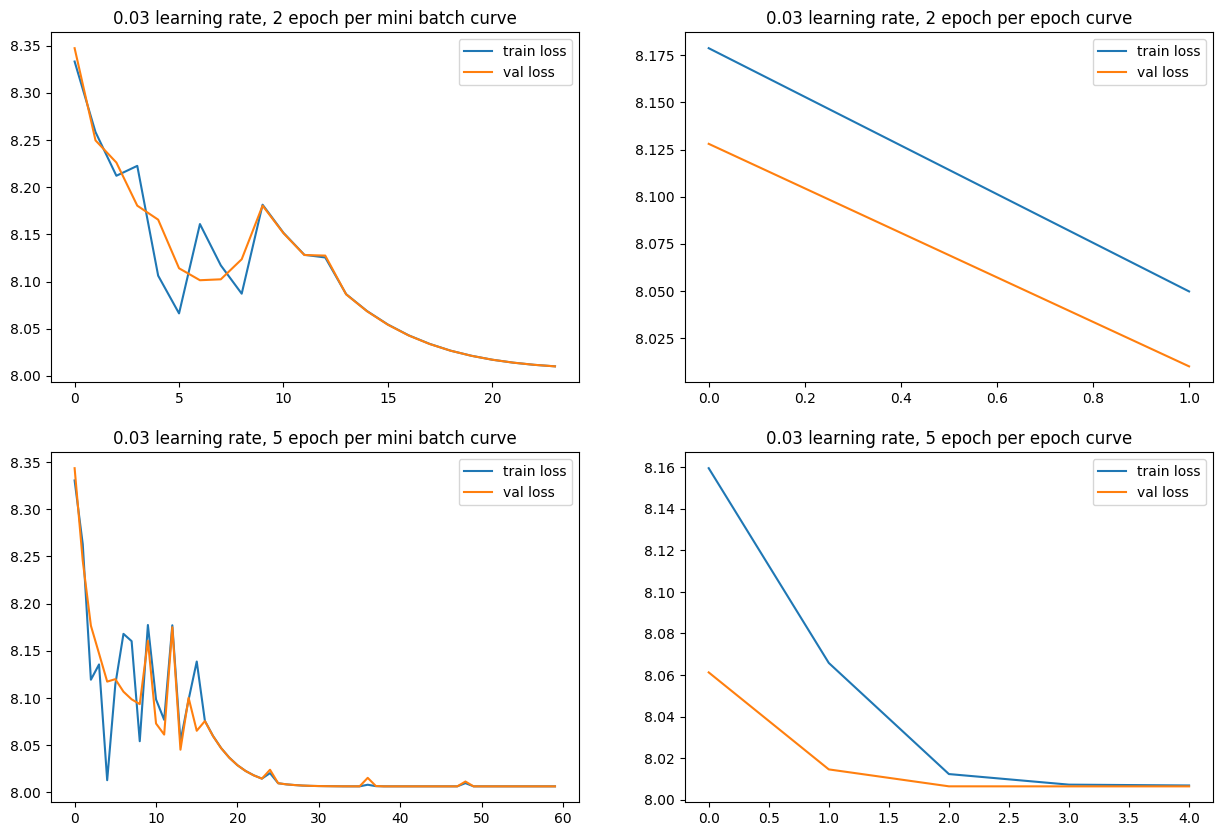

In [37]:
def extract_float(file_name, start="Epoch"):
  def isfloat(word):
    try:
      float(word)
      return True
    except ValueError:
      return False
  file = open(file_name)
  l = [[float(word) for word in re.split("\n|,| |\t|\(|\)|\[|\]", line) if isfloat(word)] for line in file if line.startswith(start)]
  return torch.tensor(l)

# general propose plot
file_names = [
  "./70524_epochs2_batch64_lr0.03_crop-num[2]-size[224]_scale-crop-min[0.14]-max[1].txt",   
  "./70527_epochs5_batch64_lr0.03_crop-num[2]-size[224]_scale-crop-min[0.14]-max[1].txt",   
]
fig, axarr = plt.subplots(len(file_names), 2, figsize=(15, 10))
names = ["0.03 learning rate, 2 epoch", "0.03 learning rate, 5 epoch"] # titles for each row of image, substitute of file name 
for i, file_name in enumerate(file_names):
  losses = extract_float(file_name) # shape [iteration_number * print num per iteration, 8], only loss at index [5, 7] are useful for plot
  train_index = {} # additional plot other than losses
  val_index = {}
  mean_loss_index = [i * 12 + 11 for i in range(losses.shape[0] // 12)]

  for j, idx in enumerate(train_index):
    axarr[i, j+1].plot(losses[:, idx])
  
  for j, idx in enumerate(val_index):
    axarr[i, j+1].plot(losses[:, idx])
    axarr[i, j+1].set_title(train_index[idx])

  axarr[i, 0].plot(losses[:, 6], label="train loss")
  axarr[i, 0].plot(losses[:, 9], label="val loss")
  axarr[i, 0].set_title(names[i] + " per mini batch curve")
  axarr[i, 0].legend(loc="upper right")


  axarr[i, -1].plot(losses[mean_loss_index, 7], label="train loss")
  axarr[i, -1].plot(losses[mean_loss_index, 9], label="val loss")
  axarr[i, -1].set_title(names[i] + " per epoch curve")
  axarr[i, -1].legend(loc="upper right")


In [33]:
losses.shape

torch.Size([24, 8])

In [ ]:
test_data = medmnist.PathMNIST("test", download=False, root=args.data_path, 
                                  #  transform=loader.TwoCropsTransform(transforms.Compose(augmentation)))
                                 transform=transforms.Compose([
                                  transforms.RandomResizedCrop(224, scale=(0.2, 1.)),
                                  transforms.ToTensor(),
                                  transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                                ]))

test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=512, shuffle=True, drop_last=True)
for x, y in test_loader:
  break

plot_test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x, y), batch_size=512)


torch.Size([512, 128]) torch.Size([512, 3000])
evaluating fepochs20_batch64_lr4.8_crop-num[2]-size[32]_scale-crop-min[0.14]-max[1]


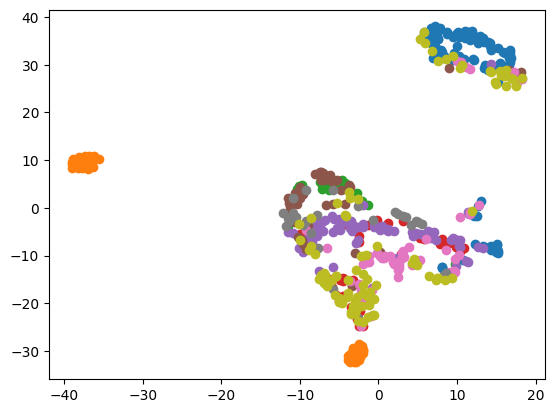

In [ ]:
eval_name = "epochs20_batch64_lr4.8_crop-num[2]-size[32]_scale-crop-min[0.14]-max[1]"
model = resnet_models.__dict__[args.arch](
        normalize=True,
        hidden_mlp=args.hidden_mlp,
        output_dim=args.feat_dim,
        nmb_prototypes=args.nmb_prototypes,
    )
model = torch.load(ROOT + f"/swav/{eval_name}.pickle", map_location=torch.device('cpu') )
model.eval()
with torch.no_grad():
  embedding, output = model.forward(x, gpu=False)
  print(embedding.shape, output.shape)
z_embedded = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=30).fit_transform(embedding)

cs = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
print(f"evaluating f{eval_name}")
for i in range(0, y.max()+1):
  plt.scatter(z_embedded[(y == i).squeeze(), 0], z_embedded[(y == i).squeeze(), 1], c=cs[i])
